In [2]:
import pandas as pd
import os
import json

# Directory containing the JSON files
json_folder = 'results/SixSolverResults'

# Initialize a dictionary to store the data
data = {}

# Define the solvers of interest
solvers = [
    "gecode_CP",
    "gecode_CP_SYM_LB",
    "gecode_CP_SYM_LB_RML_HRSTIC_GECODE",
    "chuffed_CP",
    "chuffed_CP_SYM_LB",
    "chuffed_CP_SYM_LB_RML_HRSTIC_CHUFFED",
]

# Initialize the data dictionary with solvers as keys and instance names as sub-keys
data = {solver: {f"inst{str(i).zfill(2)}": "N/A" for i in range(1, 22)} for solver in solvers}

# Iterate over each JSON file in the folder
for json_file in os.listdir(json_folder):
    if json_file.endswith('.json'):
        json_path = os.path.join(json_folder, json_file)
        with open(json_path, 'r') as file:
            json_data = json.load(file)
            instance_name = os.path.splitext(json_file)[0]
            if instance_name in data[solvers[0]]:  # Check if the instance is within the desired range
                for solver_name, solver_data in json_data.items():
                    if solver_name in data:
                        # Check if the object is null and set the value to NA
                        if solver_data.get("obj") is None:
                            data[solver_name][instance_name] = "NA"
                        else:
                            # Store the time for each instance
                            data[solver_name][instance_name] = solver_data.get("time", "N/A")

# Create a DataFrame from the collected data
df = pd.DataFrame(data).fillna("N/A")


In [3]:
print(df)

       gecode_CP gecode_CP_SYM_LB gecode_CP_SYM_LB_RML_HRSTIC_GECODE  \
inst01         0                0                                  0   
inst02       206                5                                  0   
inst03         0                0                                  0   
inst04       300              300                                 50   
inst05         0                0                                  0   
inst06       300                3                                  0   
inst07       300              300                                300   
inst08       300              190                                 30   
inst09       300               NA                                300   
inst10       300               NA                                300   
inst11       N/A              N/A                                N/A   
inst12       N/A              N/A                                300   
inst13       300              N/A                               

C:\Users\Nik.Computer\AppData\Local\Temp\ipykernel_12328\1254050007.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  color_mapped_data = df.applymap(map_value_to_color)


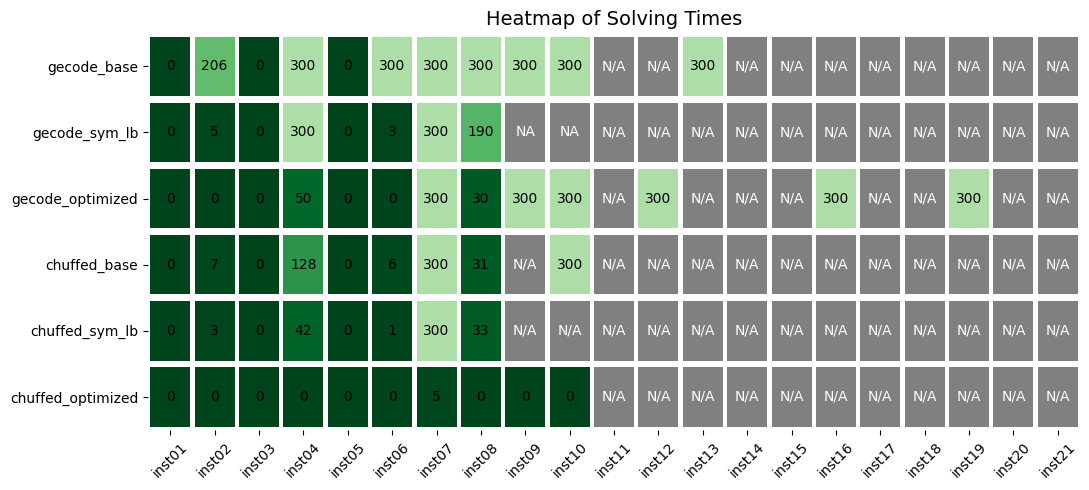

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to map values to colors
def map_value_to_color(value):
    if value == "UNSAT" or value == "NA":
        return "grey"  # Grey for UNSAT or NA
    else:
        try:
            val = float(value)
            normalized = min(max(val / 450, 0), 1)
            return plt.cm.Greens(1 - normalized)
        except ValueError:
            return "grey"

# Apply the color mapping
color_mapped_data = df.applymap(map_value_to_color)

# Filter out rows where all values are "UNSAT"
filtered_df = df.loc[~(df == "UNSAT").all(axis=1)]
filtered_color_mapped_data = color_mapped_data.loc[filtered_df.index]

# Transpose the DataFrame for plotting
transposed_filtered_df = filtered_df.transpose()
transposed_filtered_color_mapped_data = filtered_color_mapped_data.transpose()

# Create the plot
fig, ax = plt.subplots(figsize=(11, 5))
cell_size = 0.9  # Adjust the cell size for spacing
for i, row in enumerate(transposed_filtered_df.index):
    for j, col in enumerate(transposed_filtered_df.columns):
        ax.add_patch(
            plt.Rectangle(
                (j + (1 - cell_size) / 2, i + (1 - cell_size) / 2), 
                cell_size, 
                cell_size, 
                color=transposed_filtered_color_mapped_data.iat[i, j],
                linewidth=0,
                edgecolor=None,
                joinstyle='round'  # Make the corners round
            )
        )
        ax.text(
            j + 0.5,
            i + 0.5,
            transposed_filtered_df.iat[i, j],
            color="black" if transposed_filtered_color_mapped_data.iat[i, j] != "grey" else "white",
            ha="center",
            va="center",
            fontsize=10,
        )

# Adjust axis labels
ax.set_xticks(np.arange(len(transposed_filtered_df.columns)) + 0.5)
ax.set_xticklabels(transposed_filtered_df.columns, rotation=45, ha="center")
ax.set_yticks(np.arange(len(transposed_filtered_df.index)) + 0.5)
# Rename solver names based on the given instructions
renamed_columns = {
    "gecode_CP": "gecode_base",
    "gecode_CP_SYM_LB": "gecode_sym_lb",
    "gecode_CP_SYM_LB_RML_HRSTIC_GECODE": "gecode_optimized",
    "chuffed_CP": "chuffed_base",
    "chuffed_CP_SYM_LB": "chuffed_sym_lb",
    "chuffed_CP_SYM_LB_RML_HRSTIC_CHUFFED": "chuffed_optimized",
}
ax.set_yticklabels([renamed_columns.get(row, row) for row in transposed_filtered_df.index])
ax.set_xlim(0, len(transposed_filtered_df.columns))
ax.set_ylim(0, len(transposed_filtered_df.index))
ax.invert_yaxis()

# Add grid and labels
plt.title("Heatmap of Solving Times", fontsize=14)

# Hide axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig("performance_CP.png")
plt.show()